In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/4t/55hr34s50pb0bz56v_nxv0j00000gn/T/ipykernel_25014/1987216083.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [8]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
bs = 32

In [5]:
# Load Data
dataset = datasets.ImageFolder(root='./rollouts', transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(), 
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)
len(dataset.imgs), len(dataloader)

FileNotFoundError: [Errno 2] No such file or directory: './rollouts'

In [10]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'real_image.png')

Image('real_image.png')

NameError: name 'dataloader' is not defined

In [11]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [12]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [13]:
class PrintLayer(nn.Module):
    def __init__(self, name=None):
        super(PrintLayer, self).__init__()
        self.name = name
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(self.name)
        # print(x)
        print(x.shape)
        return x

In [16]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            PrintLayer('input encoder'),
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            PrintLayer('1'),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            PrintLayer('2'),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            PrintLayer('3'),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            PrintLayer('4'),
            nn.ReLU(),
            Flatten(),
            PrintLayer('Flatten'),
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            PrintLayer('input decocer'),
            UnFlatten(),
            PrintLayer('UnFlatten'),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            PrintLayer('5'),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            PrintLayer('6'),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            PrintLayer('7'),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            PrintLayer('8'),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [17]:
image_channels = fixed_x.size(1)


NameError: name 'fixed_x' is not defined

In [24]:
model = VAE(image_channels=3).to(device)
summary(model, (3, 64, 64))

input encoder
torch.Size([2, 3, 64, 64])
1
torch.Size([2, 32, 31, 31])
2
torch.Size([2, 64, 14, 14])
3
torch.Size([2, 128, 6, 6])
4
torch.Size([2, 256, 2, 2])
Flatten
torch.Size([2, 1024])
input decocer
torch.Size([2, 1024])
UnFlatten
torch.Size([2, 1024, 1, 1])
5
torch.Size([2, 128, 5, 5])
6
torch.Size([2, 64, 13, 13])
7
torch.Size([2, 32, 30, 30])
8
torch.Size([2, 3, 64, 64])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        PrintLayer-1            [-1, 3, 64, 64]               0
            Conv2d-2           [-1, 32, 31, 31]           1,568
        PrintLayer-3           [-1, 32, 31, 31]               0
              ReLU-4           [-1, 32, 31, 31]               0
            Conv2d-5           [-1, 64, 14, 14]          32,832
        PrintLayer-6           [-1, 64, 14, 14]               0
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8            [-1, 128, 

In [ ]:

model.load_state_dict(torch.load('vae.torch', map_location='cpu'))

In [20]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3) 

NameError: name 'vae' is not defined

In [14]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [14]:
!rm -rfr reconstructed
!mkdir reconstructed

In [12]:
epochs = 50

In [27]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(dataloader):
        recon_images, mu, logvar = vae(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                epochs, loss.data[0]/bs, bce.data[0]/bs, kld.data[0]/bs)
        print(to_print)

# notify to android when finished training
notify(to_print, priority=1)

torch.save(vae.state_dict(), 'vae.torch')

In [15]:
def compare(x):
    recon_x, _, _ = vae(x)
    return torch.cat([x, recon_x])

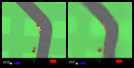

In [22]:
# sample = torch.randn(bs, 1024)
# compare_x = vae.decoder(sample)

# fixed_x, _ = next(iter(dataloader))
# fixed_x = fixed_x[:8]
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), 'sample_image.png')
display(Image('sample_image.png', width=700, unconfined=True))